<a href="https://colab.research.google.com/github/Joaquin-Aguirre-Adaros/SA-proyecto-simulaci-n-estoc-stica/blob/main/SA_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolución de sodukos mediante simulated annealing

In [ ]:
import random
import numpy as np
import math
from random import choice
import statistics

In [ ]:
def PrintSudoku(sudoku):
    print("\n")
    for i in range(len(sudoku)):
        line = ""
        if i == 3 or i == 6:
            print("---------------------")
        for j in range(len(sudoku[i])):
            if j == 3 or j == 6:
                line += "| "
            line += str(sudoku[i,j])+" "
        print(line)

def FixSudokuValues(fixed_sudoku):
    for i in range (0,9):
        for j in range (0,9):
            if fixed_sudoku[i,j] != 0:
                fixed_sudoku[i,j] = 1

    return(fixed_sudoku)

# Cost Function
def CalculateNumberOfErrors(sudoku):
    numberOfErrors = 0
    for i in range (0,9):
        numberOfErrors += CalculateNumberOfErrorsRowColumn(i ,i ,sudoku)
    return(numberOfErrors)

def CalculateNumberOfErrorsRowColumn(row, column, sudoku):
    numberOfErrors = (9 - len(np.unique(sudoku[:,column]))) + (9 - len(np.unique(sudoku[row,:])))
    return(numberOfErrors)


def CreateList3x3Blocks ():
    finalListOfBlocks = []
    for r in range (0,9):
        tmpList = []
        block1 = [i + 3*((r)%3) for i in range(0,3)]
        block2 = [i + 3*math.trunc((r)/3) for i in range(0,3)]
        for x in block1:
            for y in block2:
                tmpList.append([x,y])
        finalListOfBlocks.append(tmpList)
    return(finalListOfBlocks)

def RandomlyFill3x3Blocks(sudoku, listOfBlocks):
    for block in listOfBlocks:
        for box in block:
            if sudoku[box[0],box[1]] == 0:
                currentBlock = sudoku[block[0][0]:(block[-1][0]+1),block[0][1]:(block[-1][1]+1)]
                sudoku[box[0],box[1]] = choice([i for i in range(1,10) if i not in currentBlock])
    return sudoku

def SumOfOneBlock (sudoku, oneBlock):
    finalSum = 0
    for box in oneBlock:
        finalSum += sudoku[box[0], box[1]]
    return(finalSum)

def TwoRandomBoxesWithinBlock(fixedSudoku, block):
    while (1):
        firstBox = random.choice(block)
        secondBox = choice([box for box in block if box is not firstBox ])

        if fixedSudoku[firstBox[0], firstBox[1]] != 1 and fixedSudoku[secondBox[0], secondBox[1]] != 1:
            return([firstBox, secondBox])

def FlipBoxes(sudoku, boxesToFlip):
    proposedSudoku = np.copy(sudoku)
    placeHolder = proposedSudoku[boxesToFlip[0][0], boxesToFlip[0][1]]
    proposedSudoku[boxesToFlip[0][0], boxesToFlip[0][1]] = proposedSudoku[boxesToFlip[1][0], boxesToFlip[1][1]]
    proposedSudoku[boxesToFlip[1][0], boxesToFlip[1][1]] = placeHolder
    return (proposedSudoku)

def ProposedState (sudoku, fixedSudoku, listOfBlocks):
    randomBlock = random.choice(listOfBlocks)

    if SumOfOneBlock(fixedSudoku, randomBlock) > 6:
        return(sudoku, 1, 1)
    boxesToFlip = TwoRandomBoxesWithinBlock(fixedSudoku, randomBlock)
    proposedSudoku = FlipBoxes(sudoku,  boxesToFlip)
    return([proposedSudoku, boxesToFlip])

def ChooseNewState (currentSudoku, fixedSudoku, listOfBlocks, sigma):
    proposal = ProposedState(currentSudoku, fixedSudoku, listOfBlocks)
    newSudoku = proposal[0]
    boxesToCheck = proposal[1]
    currentCost = CalculateNumberOfErrorsRowColumn(boxesToCheck[0][0], boxesToCheck[0][1], currentSudoku) + CalculateNumberOfErrorsRowColumn(boxesToCheck[1][0], boxesToCheck[1][1], currentSudoku)
    newCost = CalculateNumberOfErrorsRowColumn(boxesToCheck[0][0], boxesToCheck[0][1], newSudoku) + CalculateNumberOfErrorsRowColumn(boxesToCheck[1][0], boxesToCheck[1][1], newSudoku)
    # currentCost = CalculateNumberOfErrors(currentSudoku)
    # newCost = CalculateNumberOfErrors(newSudoku)
    costDifference = newCost - currentCost
    rho = math.exp(-costDifference/sigma)
    if(np.random.uniform(1,0,1) < rho):
        return([newSudoku, costDifference])
    return([currentSudoku, 0])


def ChooseNumberOfItterations(fixed_sudoku):
    numberOfItterations = 0
    for i in range (0,9):
        for j in range (0,9):
            if fixed_sudoku[i,j] != 0:
                numberOfItterations += 1
    return numberOfItterations

def CalculateInitialSigma (sudoku, fixedSudoku, listOfBlocks):
    listOfDifferences = []
    tmpSudoku = sudoku
    for i in range(1,10):
        tmpSudoku = ProposedState(tmpSudoku, fixedSudoku, listOfBlocks)[0]
        listOfDifferences.append(CalculateNumberOfErrors(tmpSudoku))
    return (statistics.pstdev(listOfDifferences))


def solveSudoku (sudoku):
    f = open("demofile2.txt", "a")
    solutionFound = 0
    while (solutionFound == 0):
        decreaseFactor = 0.99
        stuckCount = 0
        fixedSudoku = np.copy(sudoku)
        PrintSudoku(sudoku)
        FixSudokuValues(fixedSudoku)
        listOfBlocks = CreateList3x3Blocks()
        tmpSudoku = RandomlyFill3x3Blocks(sudoku, listOfBlocks)
        sigma = CalculateInitialSigma(sudoku, fixedSudoku, listOfBlocks)
        score = CalculateNumberOfErrors(tmpSudoku)
        itterations = ChooseNumberOfItterations(fixedSudoku)
        if score <= 0:
            solutionFound = 1

        while solutionFound == 0:
            previousScore = score
            for i in range (0, itterations):
                newState = ChooseNewState(tmpSudoku, fixedSudoku, listOfBlocks, sigma)
                tmpSudoku = newState[0]
                scoreDiff = newState[1]
                score += scoreDiff
                print(score)
                f.write(str(score) + '\n')
                if score <= 0:
                    solutionFound = 1
                    break

            sigma *= decreaseFactor
            if score <= 0:
                solutionFound = 1
                break
            if score >= previousScore:
                stuckCount += 1
            else:
                stuckCount = 0
            if (stuckCount > 80):
                sigma += 2
            if(CalculateNumberOfErrors(tmpSudoku)==0):
                PrintSudoku(tmpSudoku)
                break
    f.close()
    return(tmpSudoku)

In [ ]:
startingSudoku = """
                    024007000
                    600000000
                    003680415
                    431005000
                    500000032
                    790000060
                    209710800
                    040093000
                    310004750
                """
sudoku = np.array([[int(i) for i in line] for line in startingSudoku.split()])

In [ ]:
solution = solveSudoku(sudoku)
print(CalculateNumberOfErrors(solution))
PrintSudoku(solution)

Se han truncado las últimas 5000 líneas del flujo de salida.
31
34
34
33
34
34
35
33
33
35
35
35
35
35
36
36
37
38
38
38
39
42
42
42
42
41
41
38
38
37
37
37
37
37
36
35
36
38
39
39
37
37
37
37
36
35
35
36
35
35
35
35
35
34
34
34
34
34
34
34
34
34
34
34
33
32
31
31
31
30
28
30
31
31
29
29
29
29
29
31
31
31
31
32
35
33
33
31
29
29
29
30
30
31
31
31
30
29
29
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
28
28
28
26
26
26
26
26
26
27
27
26
26
25
25
25
25
25
25
25
26
26
26
26
26
26
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25
26
26
25
26
26
26
26
26
26
26
27
27
27
27
27
26
26
27
25
25
26
28
27
29
29
29
29
29
27
27
27
29
29
29
31
33
31
31
31
31
31
31
31
31
31
31
34
33
33
33
33
33
33
34
34
38
38
37
37
35
35
35
34
35
35
35
32
32
32
32
32
32
34
34
34
34
35
35
35
35
35
33
35
37
37
40
40
38
37
35
35
35
35
35
32
32
32
32
31
31
31
31
29
30
30
30
30
29
30
29
31
31
31
32
32
32
32
32
32
32
32
33
32
32
32
32
31
31
31
29
27
27
27
26
26
26
26
26
27
27
27
27
27
27
27
28
28
29
29
29
28
28
28


## Resolviendo Sudoku de Emol

https://www.emol.com/movil/servicios/juegos/sudokuemol.aspx 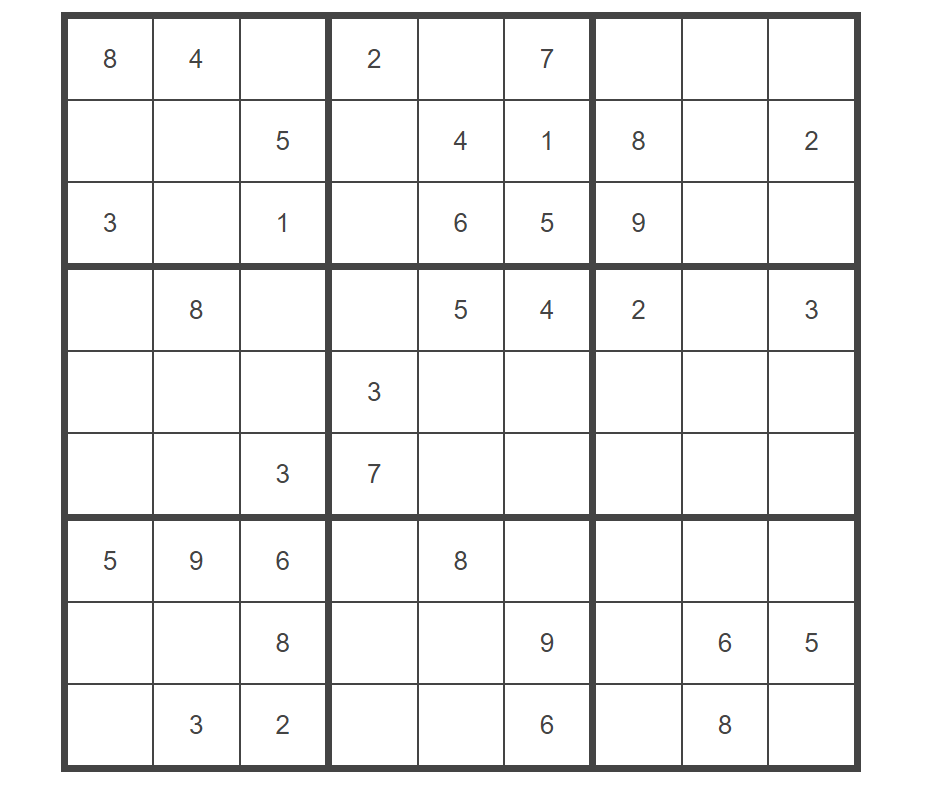

In [ ]:
startingSudoku = """
                    840207000
                    005041802
                    301065900
                    080054203
                    000300000
                    003700000
                    596080000
                    008009065
                    032006080
                """
sudoku = np.array([[int(i) for i in line] for line in startingSudoku.split()])

In [ ]:
solution = solveSudoku(sudoku)
print(CalculateNumberOfErrors(solution))
PrintSudoku(solution)

Se han truncado las últimas 5000 líneas del flujo de salida.
30
31
31
32
32
32
32
31
31
31
31
30
30
30
32
30
30
30
30
30
30
30
30
31
31
31
31
31
32
33
33
33
33
33
33
33
34
34
33
33
32
31
31
31
31
31
28
28
30
30
31
31
31
29
29
27
29
29
28
30
30
30
31
31
33
32
31
31
32
30
30
30
28
27
27
27
27
29
29
29
29
29
30
30
28
27
29
31
31
31
32
32
32
31
31
29
29
30
31
31
30
30
28
28
29
27
26
28
28
30
29
28
28
28
30
32
32
32
33
31
31
31
31
31
31
31
35
34
35
37
37
36
36
38
37
36
36
35
31
31
31
29
29
28
28
27
27
27
25
26
27
27
27
27
26
26
28
30
31
30
30
30
30
29
30
30
31
31
31
31
31
29
29
29
29
30
31
33
33
33
33
34
32
31
31
31
32
32
32
31
31
31
32
32
31
32
32
32
31
31
33
33
31
31
32
31
30
30
30
30
31
32
32
32
31
31
31
31
31
31
33
34
34
34
34
34
34
34
36
36
35
35
36
35
33
34
34
34
34
35
35
33
33
33
34
35
35
33
36
35
35
35
33
33
35
36
35
33
33
33
33
33
32
33
32
34
34
35
35
36
36
36
34
34
34
35
34
34
34
34
35
35
35
34
34
34
34
36
35
34
35
35
34
34
34
36
37
34
36
35
33
33
33
33
31
31
31
31
31
32
32
32
32
